# 1数据导入与采样的S阶段

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
model_data = pd.read_csv('donations2.csv').drop(['ID','TARGET_B'],1)
model_data.head()

,TARGET_D,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,...,PromCntCardAll,StatusCat96NK,StatusCatStarAll,DemCluster,DemAge,DemGender,DemHomeOwner,DemMedHomeValue,DemPctVeterans,DemMedIncome
0,NaN,2,4,1,3,17.0,13.50,9.25,17.00,21,...,13,A,0,0,NaN,F,U,0,0,0
1,NaN,1,8,0,3,20.0,20.00,15.88,NaN,26,...,24,A,0,23,67.0,F,U,186800,85,0
2,4.0,6,41,3,20,6.0,5.17,3.73,5.00,18,...,22,S,1,0,NaN,M,U,87600,36,38750
3,10.0,3,12,3,8,10.0,8.67,8.50,8.67,9,...,16,E,1,0,NaN,M,U,139200,27,38942
4,NaN,1,1,1,1,20.0,20.00,20.00,20.00,21,...,6,F,0,35,53.0,M,U,168100,37,71509


In [2]:
model_data.dtypes

TARGET_D            float64
GiftCnt36             int64
GiftCntAll            int64
GiftCntCard36         int64
GiftCntCardAll        int64
GiftAvgLast         float64
GiftAvg36           float64
GiftAvgAll          float64
GiftAvgCard36       float64
GiftTimeLast          int64
GiftTimeFirst         int64
PromCnt12             int64
PromCnt36             int64
PromCntAll            int64
PromCntCard12         int64
PromCntCard36         int64
PromCntCardAll        int64
StatusCat96NK        object
StatusCatStarAll      int64
DemCluster            int64
DemAge              float64
DemGender            object
DemHomeOwner         object
DemMedHomeValue       int64
DemPctVeterans        int64
DemMedIncome          int64
dtype: object

In [3]:
y = ['TARGET_D']
var_c = ["GiftCnt36","GiftCntAll","GiftCntCard36","GiftCntCardAll","GiftTimeLast",
         "GiftTimeFirst","PromCnt12","PromCnt36","PromCntAll","PromCntCard12",
         "PromCntCard36","PromCntCardAll","StatusCatStarAll","DemAge",
         "DemMedHomeValue","DemPctVeterans","DemMedIncome","GiftAvgLast",
         "GiftAvg36","GiftAvgAll","GiftAvgCard36"]
var_d = ['DemGender', 'StatusCat96NK', 'DemCluster', 'DemHomeOwner']
X = model_data[var_c+var_d]
Y = model_data[y]

In [4]:
#连续变量的重要性筛选-通过分析解释变量和被解释变量的相关性绝对值大小
corr_s = abs(model_data[y+var_c].corr(method = 'spearman'))
corr_s = pd.DataFrame(corr_s.iloc[0,:])
corr_p = abs(model_data[y+var_c].corr(method = 'pearson'))
corr_p = pd.DataFrame(corr_p.iloc[0,:])
corr_sp = pd.concat([corr_s,corr_p],axis = 1)
corr_sp.columns = ['spearman','pearson']
corr_sp[(corr_sp['spearman'] <= 0.1)&(corr_sp['pearson'] <=0.1)] 

,spearman,pearson
PromCnt12,0.009414,0.064494
PromCnt36,0.031979,0.007337
PromCntCard12,0.011849,0.006996
DemAge,0.098663,0.056139
DemPctVeterans,0.023376,0.021628
DemMedIncome,0.059946,0.029132


In [5]:
#筛选相关系数较小的解释变量
var_c_s = set(var_c) - set(['PromCnt12','PromCnt36',
                            'PromCntCard12','DemAge',
                            'DemPctVeterans','DemMedIncome'])
var_c_s = list(var_c_s)

In [6]:
#离散型变量筛选：利用解释变量与被解释变量的方差分析的显著性，将不显著的变量去掉

import statsmodels.stats.anova as anova
from statsmodels.formula.api import ols

for i in var_d:
    formula = 'TARGET_D~'+str(i)
    print(anova.anova_lm(ols(formula,data = model_data[var_d +['TARGET_D']]).fit()))

               df         sum_sq     mean_sq         F    PR(>F)
DemGender     2.0    1552.299527  776.149763  5.019571  0.006642
Residual   4840.0  748383.622667  154.624715       NaN       NaN
                   df         sum_sq      mean_sq          F        PR(>F)
StatusCat96NK     5.0   46323.378267  9264.675653  63.690218  1.487957e-64
Residual       4837.0  703612.543927   145.464657        NaN           NaN
                df         sum_sq      mean_sq          F        PR(>F)
DemCluster     1.0    7051.073357  7051.073357  45.948233  1.359482e-11
Residual    4841.0  742884.848837   153.456899        NaN           NaN
                  df         sum_sq     mean_sq        F    PR(>F)
DemHomeOwner     1.0      45.080271   45.080271  0.29102  0.589592
Residual      4841.0  749890.841922  154.904119      NaN       NaN


In [7]:
#结果DemHomeOwner 不显著，可以去除
var_d_s = list(set(var_d) - set(["DemHomeOwner"]))
var_d_s

['DemGender', 'StatusCat96NK', 'DemCluster']

# 2变量探索与变量变换（E）：

In [8]:
X = model_data[var_c_s + var_d_s].copy()
Y = model_data[y].copy()
X.head()

,GiftTimeFirst,PromCntAll,GiftCntCardAll,PromCntCardAll,GiftTimeLast,GiftCntAll,DemMedHomeValue,GiftAvgCard36,GiftAvgAll,PromCntCard36,GiftAvg36,GiftAvgLast,GiftCnt36,StatusCatStarAll,GiftCntCard36,DemGender,StatusCat96NK,DemCluster
0,66,26,3,13,21,4,0,17.00,9.25,8,13.50,17.0,2,0,1,F,A,0
1,92,79,3,24,26,8,186800,NaN,15.88,5,20.00,20.0,1,0,0,F,A,23
2,111,51,20,22,18,41,87600,5.00,3.73,11,5.17,6.0,6,1,3,M,S,0
3,93,44,8,16,9,12,139200,8.67,8.50,6,8.67,10.0,3,1,3,M,E,0
4,21,13,1,6,21,1,168100,20.00,20.00,7,20.00,20.0,1,0,1,M,F,35


In [9]:
X[var_c_s].describe().T

,count,mean,std,min,25%,50%,75%,max
GiftTimeFirst,9686.0,71.100351,37.691984,15.00,36.00,68.00,105.0,260.0
PromCntAll,9686.0,48.483481,23.061483,5.00,29.00,48.00,65.0,174.0
GiftCntCardAll,9686.0,5.582490,4.736894,0.00,2.00,4.00,8.0,41.0
PromCntCardAll,9686.0,19.007124,8.562193,2.00,12.00,19.00,26.0,56.0
GiftTimeLast,9686.0,18.002168,4.073549,4.00,16.00,18.00,20.0,27.0
GiftCntAll,9686.0,10.507640,8.993401,1.00,4.00,8.00,15.0,91.0
DemMedHomeValue,9686.0,110986.299814,98670.855450,0.00,52300.00,76900.00,128175.0,600000.0
GiftAvgCard36,7906.0,14.224431,10.022710,1.33,8.67,12.50,18.0,260.0
GiftAvgAll,9686.0,12.489325,9.209297,1.50,7.75,10.71,15.0,450.0
PromCntCard36,9686.0,11.954677,4.571568,2.00,7.00,13.00,16.0,28.0


In [10]:
#分析中位数和众数的关系来看是否存在异常值
abs((X[var_c_s].mode().iloc[0,] - X[var_c_s].median()) /
    (X[var_c_s].quantile(0.75) - X[var_c_s].quantile(0.25)))

GiftTimeFirst       0.391304
PromCntAll          0.972222
GiftCntCardAll      0.500000
PromCntCardAll      0.285714
GiftTimeLast        0.000000
GiftCntAll          0.636364
DemMedHomeValue     1.013509
GiftAvgCard36       0.267953
GiftAvgAll          0.591724
PromCntCard36       0.444444
GiftAvg36           0.168539
GiftAvgLast         0.000000
GiftCnt36           0.500000
StatusCatStarAll    0.000000
GiftCntCard36       0.000000
dtype: float64

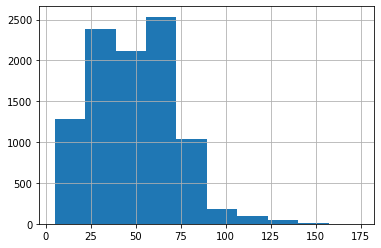

In [11]:
#大于0.8需要进一步看直方图
X["PromCntAll"].hist()

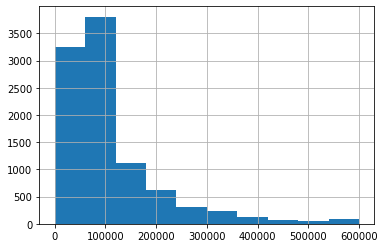

In [12]:
X["DemMedHomeValue"].hist()
#该变量有异常值0

In [13]:
X["DemMedHomeValue"].describe().T

count      9686.000000
mean     110986.299814
std       98670.855450
min           0.000000
25%       52300.000000
50%       76900.000000
75%      128175.000000
max      600000.000000
Name: DemMedHomeValue, dtype: float64

In [14]:
X["DemGender"].value_counts()

F    5223
M    3925
U     538
Name: DemGender, dtype: int64

In [15]:
X["StatusCat96NK"].value_counts()#有的水平数量太少

A    5826
S    2365
F     660
N     574
E     227
L      34
Name: StatusCat96NK, dtype: int64

In [16]:
X["DemCluster"].value_counts()[:10]

40    432
24    401
36    401
35    384
27    331
49    323
12    323
18    321
13    309
30    262
Name: DemCluster, dtype: int64

In [17]:
X["DemMedHomeValue"].replace(0,np.nan,inplace = True)

# 3变量修改的M阶段

连续变量的处理

In [18]:
#查看缺失比例
1-(X.describe().T['count'])/len(X)

GiftTimeFirst       0.000000
PromCntAll          0.000000
GiftCntCardAll      0.000000
PromCntCardAll      0.000000
GiftTimeLast        0.000000
GiftCntAll          0.000000
DemMedHomeValue     0.010634
GiftAvgCard36       0.183770
GiftAvgAll          0.000000
PromCntCard36       0.000000
GiftAvg36           0.000000
GiftAvgLast         0.000000
GiftCnt36           0.000000
StatusCatStarAll    0.000000
GiftCntCard36       0.000000
DemCluster          0.000000
Name: count, dtype: float64

In [19]:
#用中位数填充缺失值
X["GiftAvgCard36"].fillna(X["GiftAvgCard36"].median(),inplace = True)
X["DemMedHomeValue"].fillna(X["DemMedHomeValue"].median(),inplace = True)

In [20]:
#查看偏态是否严重
skew_var_x = {}
for i in var_c_s:
    skew_var_x[i] = abs(X[i].skew())
skew = pd.Series(skew_var_x).sort_values(ascending = False)
skew

GiftAvgAll          14.486489
GiftAvgLast          9.918893
GiftAvgCard36        6.747117
GiftAvg36            5.627792
DemMedHomeValue      2.412552
GiftCntAll           1.863109
GiftCntCardAll       1.331353
GiftCnt36            1.288353
GiftCntCard36        1.172452
GiftTimeLast         0.778047
PromCntAll           0.460765
PromCntCard36        0.426600
GiftTimeFirst        0.195399
StatusCatStarAll     0.162858
PromCntCardAll       0.142856
dtype: float64

In [21]:
#对于偏态严重的连续变量（大于1），可以进行对数变换
var_x_ln = skew[skew >= 1].index
var_x_ln

Index(['GiftAvgAll', 'GiftAvgLast', 'GiftAvgCard36', 'GiftAvg36',
       'DemMedHomeValue', 'GiftCntAll', 'GiftCntCardAll', 'GiftCnt36',
       'GiftCntCard36'],
      dtype='object')

In [22]:
#对于偏态较大的变量，进行对数变换：
for i in var_x_ln:
    if min(X[i]) <=0:
        X[i] = np.log(X[i]+abs(min(X[i])) + 0.1)
    else:
        X[i] = np.log(X[i])

In [23]:
#查看修正后的结果，偏态有所改善
skew_var_x = {}
for i in var_c_s:
    skew_var_x[i]=abs(X[i].skew())

skew = pd.Series(skew_var_x).sort_values(ascending=False)
skew

GiftAvg36           3.147058
GiftAvgLast         1.546238
GiftCntCardAll      1.241994
GiftCnt36           1.030483
GiftCntCard36       1.015788
GiftTimeLast        0.778047
DemMedHomeValue     0.586459
PromCntAll          0.460765
GiftCntAll          0.457529
PromCntCard36       0.426600
GiftAvgAll          0.219720
GiftTimeFirst       0.195399
StatusCatStarAll    0.162858
PromCntCardAll      0.142856
GiftAvgCard36       0.031261
dtype: float64

分类变量处理

In [24]:
#对DemCluster分类变量进行概化
DemC_group = model_data[['DemCluster','TARGET_D']].groupby('DemCluster',as_index = False)
DemC_C = DemC_group['TARGET_D'].agg({'mean':'mean','count':'count','median':'median'}).sort_values(['median','mean'])
DemC_C["count_cumsum"] = DemC_C["count"].cumsum()
DemC_C["new_DemCluster"] = DemC_C["count_cumsum"].apply(lambda x:x//(len(model_data)/10)+1)
DemC_C["new_DemCluster"] = DemC_C["new_DemCluster"].astype(int)
DemC_C.head()

,DemCluster,mean,count,median,count_cumsum,new_DemCluster
52,52,10.769231,13,10.0,13,1
30,30,12.091743,109,10.0,122,1
47,47,12.411765,34,10.0,156,1
51,51,12.693069,101,10.0,257,1
45,45,13.180190,105,10.0,362,1


In [25]:
#把概化后的结果写入X
DemCluster_new_class = DemC_C[["DemCluster","new_DemCluster"]].set_index("DemCluster")
X["DemCluster"] = X["DemCluster"].map(DemCluster_new_class.to_dict()['new_DemCluster'])
X

,GiftTimeFirst,PromCntAll,GiftCntCardAll,PromCntCardAll,GiftTimeLast,GiftCntAll,DemMedHomeValue,GiftAvgCard36,GiftAvgAll,PromCntCard36,GiftAvg36,GiftAvgLast,GiftCnt36,StatusCatStarAll,GiftCntCard36,DemGender,StatusCat96NK,DemCluster
0,66,26,1.131402,13,21,1.386294,11.260611,2.833213,2.224624,8,2.610070,2.839078,0.741937,0,0.095310,F,A,3
1,92,79,1.131402,24,26,2.079442,12.137794,2.525729,2.765060,5,3.000720,3.000720,0.095310,0,-2.302585,F,A,2
2,111,51,3.000720,22,18,3.713572,11.380536,1.609438,1.316408,11,1.662030,1.808289,1.808289,1,1.131402,M,S,3
3,93,44,2.091864,16,9,2.484907,11.843667,2.159869,2.140066,6,2.171337,2.312535,1.131402,1,1.131402,M,E,3
4,21,13,0.095310,6,21,0.000000,12.032314,2.995732,2.995732,7,3.000720,3.000720,0.095310,0,0.095310,M,F,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,24,27,0.741937,11,17,0.693147,11.130200,2.708050,2.708050,12,2.714695,2.312535,0.741937,0,0.741937,M,N,2
9682,32,29,0.095310,13,25,1.386294,11.183032,2.302585,2.442347,15,2.597491,2.312535,1.131402,0,0.095310,U,A,2
9683,55,46,1.960095,18,15,2.639057,11.658756,2.174752,2.042518,17,2.183802,2.312535,2.208274,1,1.629241,F,S,3
9684,56,42,0.095310,16,6,1.945910,11.574021,2.525729,2.005526,6,2.533697,1.629241,0.741937,0,-2.302585,M,A,3


In [26]:
#其他分类变量的处理
new_DemGender = {"F":1,"M":2,"U":3}
X['DemGender'] = X['DemGender'].map(new_DemGender)

In [27]:
#对StatusCat96NK进行水平合并。
#水平合并是把均值接近的被解释变量合并在一起，一般转变为样本接近的二分类变量。
StatusCat96NK_group = model_data[['StatusCat96NK','TARGET_D']].groupby('StatusCat96NK', as_index = False)
StatusCat96NK_class = StatusCat96NK_group['TARGET_D'].agg({'mean' : 'mean', 'count':'count',"median":"median"}).sort_values(["median","mean"])
StatusCat96NK_class

,StatusCat96NK,mean,count,median
5,S,11.063452,1379,10.0
0,A,16.995004,2794,15.0
1,E,17.136364,132,15.0
4,N,17.654167,264,15.0
2,F,21.729416,257,20.0
3,L,24.764706,17,25.0


In [28]:
new_StatusCat96NK = {"S":1,"A":2,"E":2,"N":2,"F":2,"L":2}
X['StatusCat96NK'] = X['StatusCat96NK'].map(new_StatusCat96NK)
X.head()

,GiftTimeFirst,PromCntAll,GiftCntCardAll,PromCntCardAll,GiftTimeLast,GiftCntAll,DemMedHomeValue,GiftAvgCard36,GiftAvgAll,PromCntCard36,GiftAvg36,GiftAvgLast,GiftCnt36,StatusCatStarAll,GiftCntCard36,DemGender,StatusCat96NK,DemCluster
0,66,26,1.131402,13,21,1.386294,11.260611,2.833213,2.224624,8,2.610070,2.839078,0.741937,0,0.095310,1,2,3
1,92,79,1.131402,24,26,2.079442,12.137794,2.525729,2.765060,5,3.000720,3.000720,0.095310,0,-2.302585,1,2,2
2,111,51,3.000720,22,18,3.713572,11.380536,1.609438,1.316408,11,1.662030,1.808289,1.808289,1,1.131402,2,1,3
3,93,44,2.091864,16,9,2.484907,11.843667,2.159869,2.140066,6,2.171337,2.312535,1.131402,1,1.131402,2,2,3
4,21,13,0.095310,6,21,0.000000,12.032314,2.995732,2.995732,7,3.000720,3.000720,0.095310,0,0.095310,2,2,4


筛选变量

In [29]:
#向前选择法筛选变量
import statsmodels.formula.api as smf
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return selected

In [30]:
XX = pd.concat([X,Y],axis = 1)

In [31]:
final_var = forward_selected(XX,'TARGET_D')

In [32]:
final_var

['GiftAvgAll',
 'GiftAvgLast',
 'GiftAvg36',
 'GiftCntAll',
 'GiftAvgCard36',
 'PromCntCard36',
 'DemGender',
 'PromCntCardAll',
 'DemMedHomeValue',
 'PromCntAll']

In [39]:
var_c_s = list(set(var_c_s)&set(final_var))
var_d_s = list(set(var_d_s)&set(final_var))
print(var_c_s,'+',var_d_s)

['PromCntAll', 'GiftAvg36', 'PromCntCard36', 'GiftAvgCard36', 'GiftCntAll', 'GiftAvgAll', 'PromCntCardAll', 'DemMedHomeValue', 'GiftAvgLast'] + ['DemGender']


In [40]:
model_final = pd.concat([X[var_d_s+var_c_s],Y],axis = 1)
model_final.columns

Index(['DemGender', 'PromCntAll', 'GiftAvg36', 'PromCntCard36',
       'GiftAvgCard36', 'GiftCntAll', 'GiftAvgAll', 'PromCntCardAll',
       'DemMedHomeValue', 'GiftAvgLast', 'TARGET_D'],
      dtype='object')

# 4建立线形回归模型

In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
X = model_final.iloc[:,:-1]
Y = model_final.iloc[:,-1]

formula = 'TARGET_D ~ ' + '+'.join(final_var) 
donation_model = ols(formula,model_final).fit()
print(donation_model.summary())

                            OLS Regression Results                            
Dep. Variable:               TARGET_D   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     381.5
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:39:34   Log-Likelihood:                -17673.
No. Observations:                4843   AIC:                         3.537e+04
Df Residuals:                    4832   BIC:                         3.544e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -28.1524      2.402    -

In [54]:
#去除显著性不明显的解释变量
dis_var = ['DemMedHomeValue','PromCntAll']
final_var = list(set(final_var)-set(dis_var))

In [55]:
formula = 'TARGET_D ~ ' + '+'.join(final_var) 
donation_model = ols(formula,model_final).fit()
print(donation_model.summary())

                            OLS Regression Results                            
Dep. Variable:               TARGET_D   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     476.4
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:46:52   Log-Likelihood:                -17674.
No. Observations:                4843   AIC:                         3.537e+04
Df Residuals:                    4834   BIC:                         3.543e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -26.0380      1.050    -24.